In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

import medmnist
from medmnist import PathMNIST

In [9]:
train_dataset = PathMNIST(split="train", download=True)
val_dataset   = PathMNIST(split="val", download=True)
test_dataset  = PathMNIST(split="test", download=True)

In [10]:
set(train_dataset.labels.flatten())

{np.uint8(0),
 np.uint8(1),
 np.uint8(2),
 np.uint8(3),
 np.uint8(4),
 np.uint8(5),
 np.uint8(6),
 np.uint8(7),
 np.uint8(8)}

In [16]:
# Wyciągamy obrazy i etykiety
train_X = train_dataset.imgs        # (N, 28, 28, 3)
train_y = train_dataset.labels.ravel()  # (N,)

# Ograniczamy do dwóch klas, np. 0 i 1
allowed_classes = [0, 1]
mask = np.isin(train_y, allowed_classes)

train_df = pd.DataFrame({
    "index": np.arange(len(train_y))[mask],
    "target": train_y[mask]
})

# Analiza eksploracyjna danych

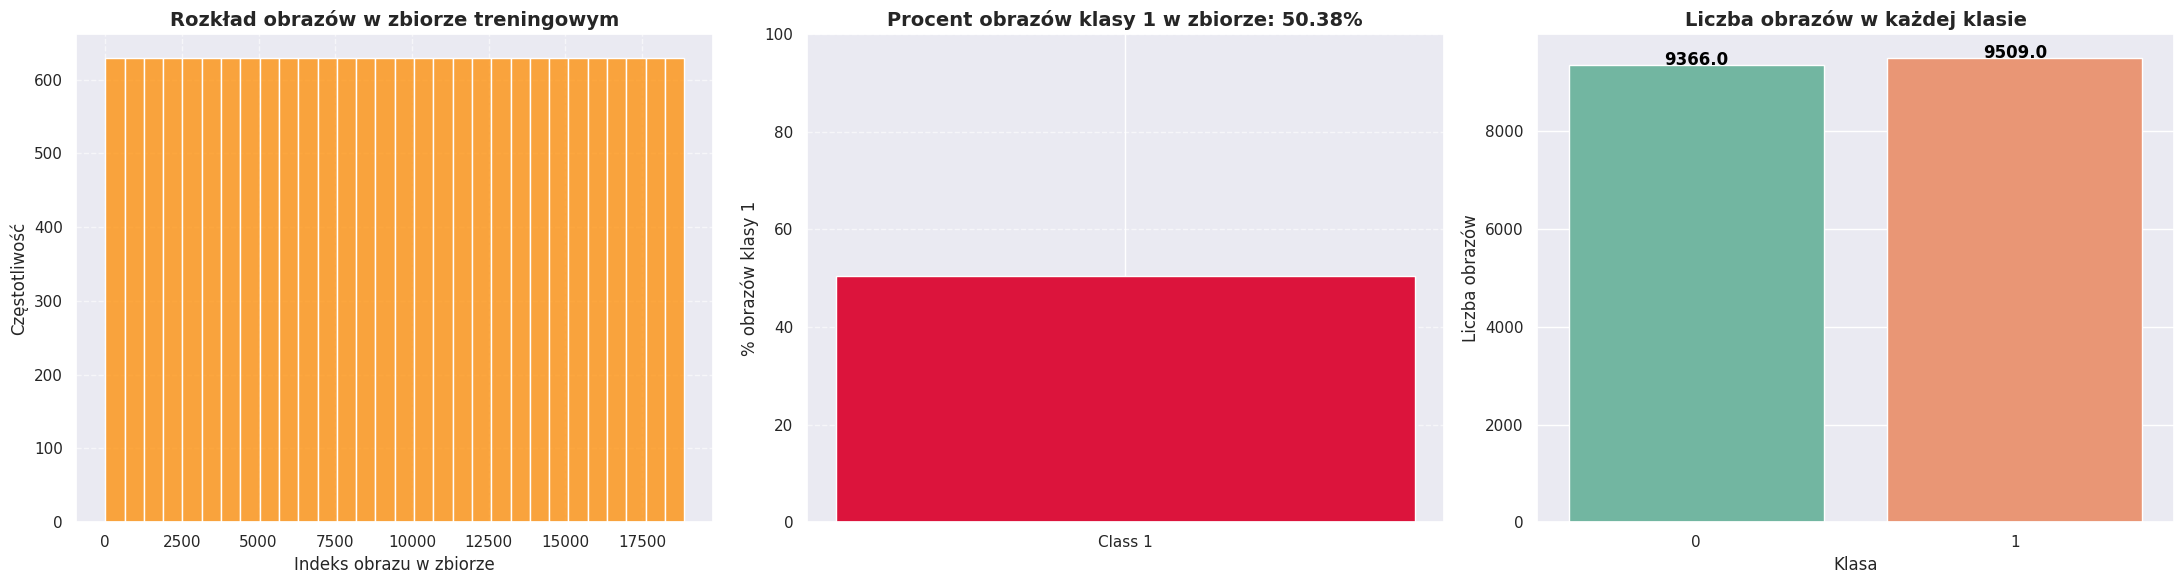

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = train_df.copy()

fig, ax = plt.subplots(1, 3, figsize=(22, 6))

# Rozkład indeksów (kolejność w dataset, tylko wizualizacja liczby obrazów)
sns.histplot(df.index, ax=ax[0], color="darkorange", bins=30)
ax[0].set_xlabel("Indeks obrazu w zbiorze", fontsize=12)
ax[0].set_ylabel("Częstotliwość", fontsize=12)
ax[0].set_title("Rozkład obrazów w zbiorze treningowym", fontsize=14, fontweight="bold")
ax[0].grid(True, linestyle="--", alpha=0.6)

# Procentowy udział klasy 1 w zbiorze
perc_class1 = df['target'].mean() * 100
ax[1].bar(["Class 1"], [perc_class1], color="crimson")
ax[1].set_ylim(0, 100)
ax[1].set_ylabel("% obrazów klasy 1", fontsize=12)
ax[1].set_title(f"Procent obrazów klasy 1 w zbiorze: {perc_class1:.2f}%", fontsize=14, fontweight="bold")
ax[1].grid(True, axis="y", linestyle="--", alpha=0.6)

# Liczba obrazów w każdej klasie
sns.countplot(x="target", data=df, palette="Set2", ax=ax[2])
ax[2].set_xlabel("Klasa", fontsize=12)
ax[2].set_ylabel("Liczba obrazów", fontsize=12)
ax[2].set_title("Liczba obrazów w każdej klasie", fontsize=14, fontweight="bold")

for p in ax[2].patches:
    ax[2].annotate(f"{p.get_height()}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha="center", va="baseline", fontsize=12, color="black", fontweight="bold")

plt.tight_layout()
plt.show()


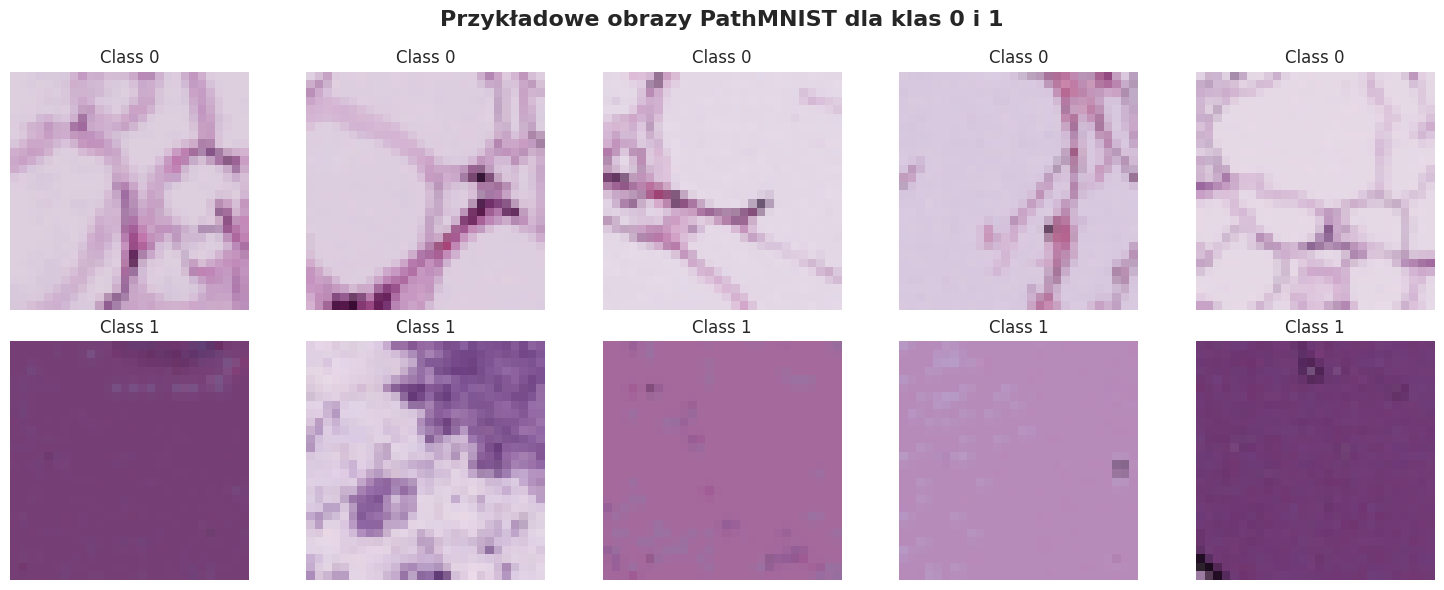

In [18]:
# Wybieramy kilka losowych indeksów dla każdej klasy
num_samples = 5 
class0_idx = np.where(train_y == 0)[0]
class1_idx = np.where(train_y == 1)[0]

sample0 = np.random.choice(class0_idx, num_samples, replace=False)
sample1 = np.random.choice(class1_idx, num_samples, replace=False)

fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

# Wyświetlamy klasę 0
for i, idx in enumerate(sample0):
    axes[0, i].imshow(train_X[idx])
    axes[0, i].axis('off')
    axes[0, i].set_title("Class 0")

# Wyświetlamy klasę 1
for i, idx in enumerate(sample1):
    axes[1, i].imshow(train_X[idx])
    axes[1, i].axis('off')
    axes[1, i].set_title("Class 1")

plt.suptitle("Przykładowe obrazy PathMNIST dla klas 0 i 1", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()